# 생성모델링
- 없던 데이터를 생성해 내는 것이 목표
- 각 이미지의 특징을 학습해 그와 비슷한 새로운 사진을 만들어내야 한다.
### 판별모델
- 입력된 데이터셋을 특정 기준에 따라 분류하거나, 특정 값을 맞추는 모델

### 생성모델
- 학습한 데이터셋과 비슷하면서도 기존에는 없던 새로운 데이터셋을 생성하는 모델

# Pix2Pix
### 그림을 사진으로 변환
- ```Pix2Pix``` : 간단한 이미지를 입력할 경우 실제 사진처럼 보이도록 바꿔줄 때 사용하는 모델
- Ground Truth 이미지와 input image를 얼마나 비슷한지를 평가하며 실제 같은 결과물(Predicted image)을 만들어낸다.
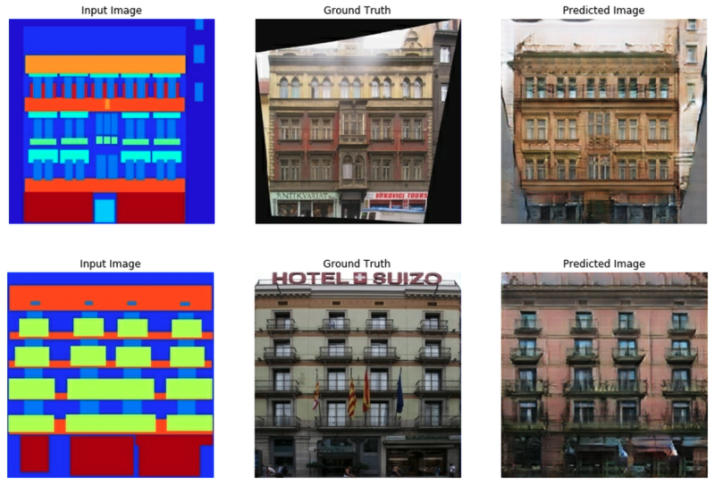

# CycleGAN
### 그림을 사진으로, 사진을 그림으로
- 한 이미지와 다른 이미지를 번갈아 가며 Cyclic하게 변환
- 쌍으로 이루어진 데이터셋이 필요가없다.

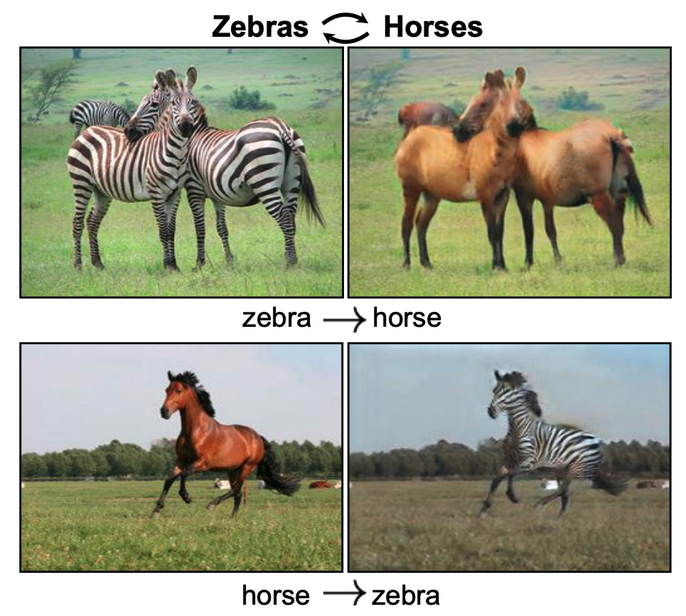

# Neural Style Transfer
### 사진에 스타일을 입힌다
- 전체 이미지의 구성을 유지하는 Base Image와 입히고 싶은 스타일이 담긴 Style Image 두장을 활용하여 새로운 이미지를 만들어낸다.
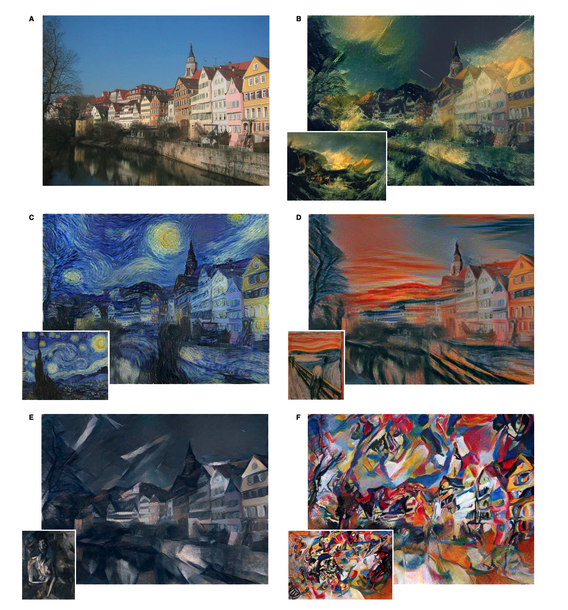

- 맨 왼쪽 이미지가 Base Image이고, 다섯개의 이미지에 붙어있는 이미지가 Style Image

- ```Neural Style Transfer``` 를 검색

# 1. 데이터 가져오기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

- 분류 문제에서와 달리, 라벨이 없다. 고로 ```y_train``` , ```y_test```에 해당하는 데이터를 쓰지않는다.
- 그래서 y 에 해당하는 부분에 ```_```로 해당 데이터들은 무시

In [2]:
# 데이터셋 가져오기
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_x, _),(test_x, _) = fashion_mnist.load_data()

In [3]:
# fashion mnist의 최대값과 최소값
print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 255
min pixel: 0


- 각 픽셀을 -1~ 1로 정규화시켜야 하므로, 중간값을 0으로 맞춰주기 위해 127.5를 빼고 127.5로 나눈다

In [4]:
train_x = (train_x-127.5)/127.5 # [-1,1]로 정규화
print('max pixel :', train_x.max())
print('min pixel :', train_x.min())

max pixel : 1.0
min pixel : -1.0


In [5]:
# data shape
train_x.shape

(60000, 28, 28)

딥러닝에서 이미지를 다루려면 **채널수** 차원이 필요하다. 그래서 fashion mnist는 흑백이미지이므로 1을 추가해야한다.

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28,28,1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

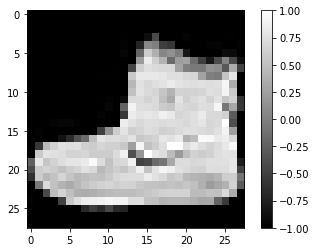

In [7]:
plt.imshow(train_x[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

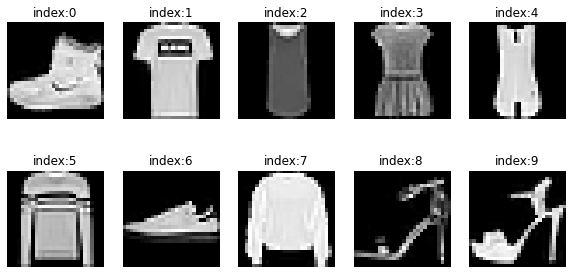

In [8]:
# 10개 이미지 보기
plt.figure(figsize=(10,5)) # 이미지의 전체 프레임 크기

for i in range(10):
    plt.subplot(2,5, i+1)
    plt.imshow(train_x[i].reshape(28,28), cmap='gray')
    plt.title(f'index:{i}')
    plt.axis('off')
plt.show

- `plt.subplot(row,col,index)`의 형태로 본다. `plt.subplot(2,5,index)`는 2X5배열형태로 보고싶은경우
- index는 1~10까지 순서대로 바뀌어야 하므로 for문에서 i에 i+1을 넣어주면 된다.
- `plt.axis('off')` 함수로 불필요한 축을 지워서 깔끔하게

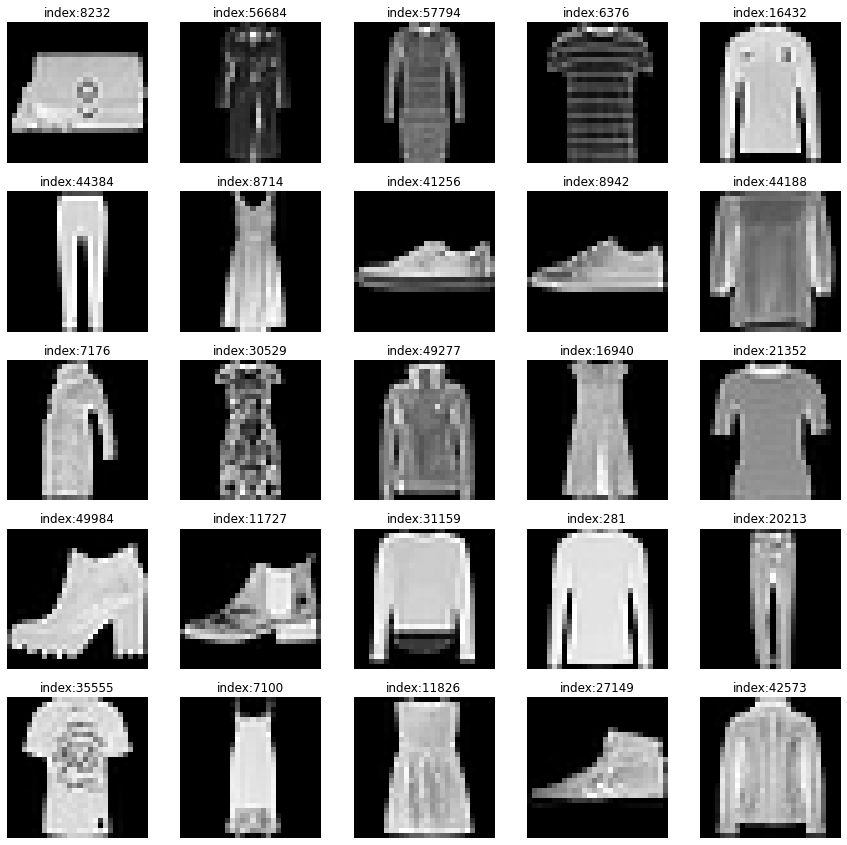

In [9]:
# random으로 25개를 추출하여 5X5 배열로 띄워보기
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    random = np.random.randint(1, 60000)
    plt.imshow(train_x[random].reshape(28,28), cmap='gray')
    plt.title('index:{}'.format(random))
    plt.axis('off')
plt.show()

In [10]:
BUFFER_SIZE = 60000 # 전체 데이터를 섞기 위해 60,000으로 설정

BATCH_SIZE = 256 # 모델이 한 번에 학습할 데이터 양 (미니배치)

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- ```from_tensor_slices```함수는 리스트,넘파이,텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다.

# 2. GAN 이해
### GAN이란?
두가지 네트워크가 있다.

- `생성자(Generator)` : 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성.
- `판별자(Discriminator)` : 기존의 이미지와 생성자가 만들어낸 이미지를 입력받아 real, fake 판단 정도를 실수값으로 출력

# 3. 생성자 구현
### DCGAN

https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko


https://excelsior-cjh.tistory.com/159

In [12]:
# 생성자 함수
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    ## 입력값으로 (batch_size, 100)형상의 노이즈벡터를 받고, dense layer를 거치며 (batch_size, 12544)형태의 벡터
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 신경망의 가중치가 폭발하지 않도록 가중치 값 정규화
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256))) # 12544 형태의 1차원 벡터를 3차원 벡터로 변환시키는 작업

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) # 신경망의 가중치가 폭발하지 않도록 가중치 값 정규화
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) # 신경망의 가중치가 폭발하지 않도록 가중치 값 정규화
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) # 활성화 함수 tanh를 사용하는 이유는 -1~1 사이의 값으로 픽셀 값을 정규화시켜서

    return model

- ```Conv2DTranspose``` 층은 일반적인 ```Conv2D```와 반대로 이미지 사이즈를 넓혀주는 층
- 세 번의 층을 이용하여 이미지를 키워나간다. (7,7,256) -> (14,14,64) -> (28,28,1) 순으로

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False) # 학습하는 중이 아니므로 training = False
generated_image.shape

TensorShape([1, 28, 28, 1])

- [1,28,28,1]는 batch_size=1, 28X28X1 사이즈 이미지가 생성되었다는 뜻

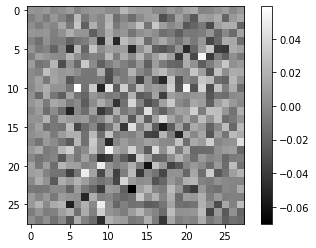

In [16]:
# 노이즈 시각화
plt.imshow(generated_image[0,:,:,0], cmap='gray') # matplotlib은 2차원 이미지만 보여주므로 0번째,3번째인덱스는 0으로
plt.colorbar()
plt.show()

# 4. 판별자 구현
- 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 진짜라고 판단하는 정도 값을 출력해야한다.
- 고로 입력은 (28,28,1) 크기의 이미지가,출력은 단 하나의 숫자가 된다.

In [17]:
# 판별자 구현 함수
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    ## Conv2D 층으로 이미지의 크기를 줄인다.
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    ## [28,28,1] -> [14,14,64]

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    ## [14,14,64] -> [7,7,128]

    # Third: Flatten Layer
    # 3차원 이미지를 1차원으로 변환 (1,6272) 형태의 벡터로
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1)) # 단 하나의 값 출력

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [19]:
# 가짜 이미지를 판별자에 입력
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00186752]], dtype=float32)>

# 5. 손실함수와 최적화 함수
### 손실함수(loss function)
- GAN은 Cross Entropy를 사용한다
- 분류 모델을 설계할 때 많이 사용했던 손실함수, 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 계산할 때 사용
- 판별자는 한개의 이미지가 진짜,가짜를 판별하기위한 분류 문제를 풀어야하므로 binary cross entropy사용

라벨값

- Real image : 1, Fake image : 0 일때

- 생성자 : 판별자가 Fake image에 대해 판별한 값, D(fake_image)에 값이 1에 가까워지는 것이 목적
- 판별자 : Real image 판별값, D(real_image)값이 1, D(fake_image)값이 0에 가까워지는 것이 목적

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- 판별자의 모델 마지막에는 값을 정규화시키는 활성화함수가 없었는데, 구분자가 출력하는 값은 범위가 정해지지않아 모든 실수값을 가진다.
- 근데 binary cross entropy에는 인풋값이 0 ~ 1 사이에 분포하는 확률값을 원하므로, `from_logits`를 True로 해줘야 함수내부에서 sigmoid로 0 ~ 1사이값으로 정규화 시켜준다.

이제 `cross entropy`를 활용하여 계산할 loss들은 `fake_output`과 `real_output` 두가지를 활용한다.
- fake_output : 생성자가 생성한 fake image를 구분자에 입력시켜서 판별된 값, `D(fake_image)`
- real_output : 기존의 Real image를 구분자에 입력시켜서 판별된 값, `D(real_image)`


- fakeoutput과 real_output을 각각 1또는 0에 비교를 해야하는데

``` tf.ones_like()```와 `tf.zeros_like()`함수 활용

### generator_loss
- `generator_loss`는 `fake_out`이 1에 가까워지기를 바라므로, `tf.ones_like`와의 교차 엔트로피값을 계산한다.

In [21]:
# 1에 가까울수록 작은값을 가진다.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
- `discriminator_loss`는 `real_output`은 1에, `fake_output`은 0에 가까워지기를 바라므로, 두 loss값을 모두 계산
- `real_output`은 `tf.ones_like`벡터와, `fake_output`은 `tf.zeros_like`벡터와 비교

In [22]:
# 최종값은 둘을 더한값
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # real image와 1vector간의 차이
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # fake image와 0vector간의 차이
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator_accuracy
- 판별자가 real, fake output을 정확하게 판별하는지의 accuracy계산도 중요하다.
- 둘 다 1.0에 가까우면 판별을 쉽게 하고 있는것이므로 좋지않다. 둘다 `accuracy 0.5`가 이상적인 수치

In [23]:
def discriminator_accuracy(real_output, fake_output):
    
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- `tf.math.greater_equal(real_output, tf.constant([0.5])` : real_output 각 원소가 0.5이상인지 boolean으로 판별
- `tf.cast(x, tf.float32)` : 위의 결과가 True면 1.0, False면 0.0으로 변환
- `tf.reduce_mean` : 총 결과를 평균내어 정확도 계산

### optimizer
#### Adam

In [25]:
# 생성자와 구분자는 따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어줘야한다.
generator_optimizer, discriminator_optimizer = tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.Adam(1e-4)

In [26]:
noise_dim=100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 훈련과정 설계

In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터 , 하나의 배치 당 진행 할 함수
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈, 256개 만큼 fake image생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈, Gradient를 자동미분으로 계산하기 위해
        generated_images = generator(noise, training=True)  #(4) generated_images 생성, noise입력 받고 함수를 통한 fake image생성

        #(5) discriminator 판별, real image와 fake image를 입력받고 output출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산 , fake_output, real_output으로 생성자와 판별자 loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산, fake_output, real_output의 판별자 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산,
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습, 계산된 기울기를 optimizer에 입력하여 가중치 갱신-
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- 이 과정이 한번의 train_step

In [28]:
# sample_seed를 받아 만들어낸 prediction을 시각화
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [29]:
# train_step 함수가 리턴하는 값들 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [30]:
# checkpoint 저장
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [32]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

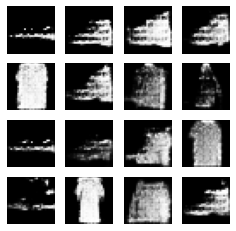

Time for training : 2680 sec


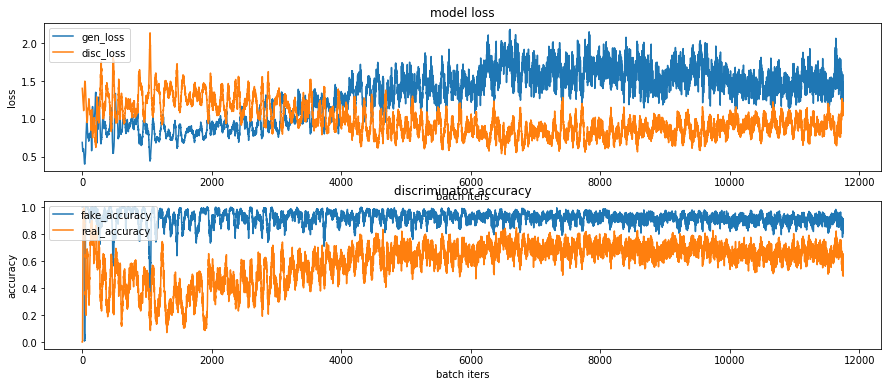

CPU times: user 12min, sys: 55.3 s, total: 12min 56s
Wall time: 44min 41s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [34]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1281605 Nov 11 16:53 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
